# Análise da variação no preço da ação da Petrobras #

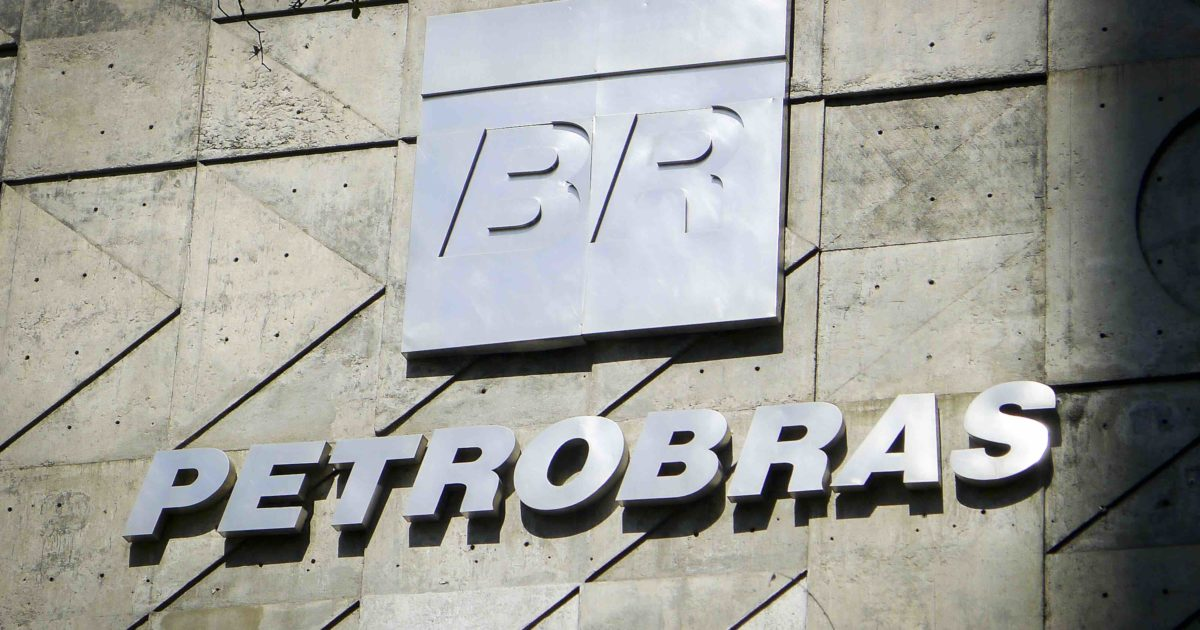

In [6]:
import pandas_datareader.data as web
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from datetime import datetime

In [7]:
start_date = datetime(2000,1,1)
end_date = datetime(2022,7,31)
acoes = {ticker: web.get_data_yahoo(ticker, start_date, end_date) for ticker in ['PETR4.SA']}
acoes

{'PETR4.SA':                  High        Low       Open      Close        Volume  \
 Date                                                                   
 2000-01-03   5.875000   5.875000   5.875000   5.875000  3.538944e+10   
 2000-01-04   5.550000   5.550000   5.550000   5.550000  2.886144e+10   
 2000-01-05   5.494000   5.494000   5.494000   5.494000  4.303360e+10   
 2000-01-06   5.475000   5.475000   5.475000   5.475000  3.405568e+10   
 2000-01-07   5.500000   5.500000   5.500000   5.500000  2.091264e+10   
 ...               ...        ...        ...        ...           ...   
 2022-07-25  30.750000  29.610001  29.610001  30.700001  7.910660e+07   
 2022-07-26  31.620001  30.590000  31.200001  31.010000  7.836010e+07   
 2022-07-27  31.469999  30.620001  31.299999  31.350000  5.609720e+07   
 2022-07-28  32.630001  31.430000  31.590000  32.290001  1.149965e+08   
 2022-07-29  34.660000  32.830002  33.599998  34.150002  1.814806e+08   
 
             Adj Close  
 Date       

### Transformando os dados para a sua variação ###

In [8]:
petrobras = acoes['PETR4.SA'].pct_change()
petrobras.dropna(inplace=True)

In [9]:
petrobras.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-04,-0.055319,-0.055319,-0.055319,-0.055319,-0.184462,-0.055319
2000-01-05,-0.010090,-0.010090,-0.010090,-0.010090,0.491041,-0.010090
2000-01-06,-0.003458,-0.003458,-0.003458,-0.003458,-0.208626,-0.003459
2000-01-07,0.004566,0.004566,0.004566,0.004566,-0.385928,0.004566
2000-01-10,0.020545,0.020545,0.020545,0.020545,-0.064512,0.020546


In [10]:
petrobras = petrobras.resample('1M').mean()
petrobras.index = pd.to_datetime(petrobras.index)
petrobras.index = petrobras.index.map(lambda x: x.strftime('%Y-%m'))

In [11]:
petrobras.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01,-0.006899,-0.006899,-0.006899,-0.006899,NaN,-0.006899
2000-02,0.006246,0.006246,0.006246,0.006246,0.183813,0.006246
2000-03,0.001382,0.001382,0.001382,0.001382,NaN,0.001382
2000-04,-0.003893,-0.003893,-0.003893,-0.003893,NaN,-0.003893
2000-05,-0.001019,-0.001019,-0.001019,-0.001019,NaN,-0.001019


### Média móvel ###

<AxesSubplot:xlabel='Date'>

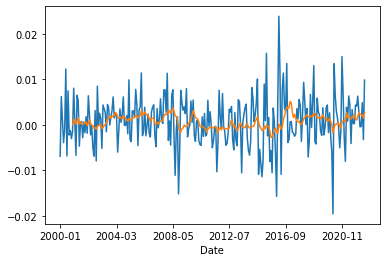

In [12]:
petrobras['Adj Close'].plot()
petrobras['Adj Close'].rolling(12).mean().plot()

### Desvio padrão da média móvel ###

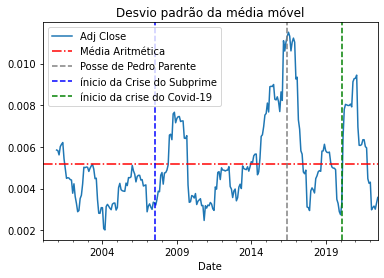

In [13]:
return_desvpad = petrobras['Adj Close'].rolling(12).std()
return_desvpad.index = pd.to_datetime(return_desvpad.index, format="%Y-%m")

ax, fig = plt.subplots()
return_desvpad.plot().set_title("Desvio padrão da média móvel")
plt.axhline(return_desvpad.mean(), color='red', ls = '-.', label='Média Aritmética')
plt.axvline(pd.Timestamp("2016-06-01"), label="Posse de Pedro Parente", ls='--', color="Grey")
plt.axvline(pd.Timestamp("2007-07-01"), label="ínicio da Crise do Subprime", ls='--', color="blue")
plt.axvline(pd.Timestamp("2020-02-01"), label="ínicio da crise do Covid-19", ls='--', color='green')
plt.legend()
plt.show()

#### Com o desvio padrão da média móvel, pode-se notar dois grandes picos anteriores a posse de Pedro Parente e da mudança na política de preços em 2016, sendo que o primeiro pico de variação se seguiu a partir da descoberta do pré-sal em 2006, e durante a Crise do Subprime entre 2007 e 2008, tendo fim em meados de 2009, e o segundo pico de meados de 2012 até o ano de 2016, quando houve mudança na presidência da empresa e na política de preços. Assim, o preço da ação PETR4 está associada a pequenos ciclos de variações no curto prazo, e eventuais ciclos mais longos que envolvem variações mais expressivas, como vem ocorrendo desde o ano de 2020 com a crise do COVID-19. ####

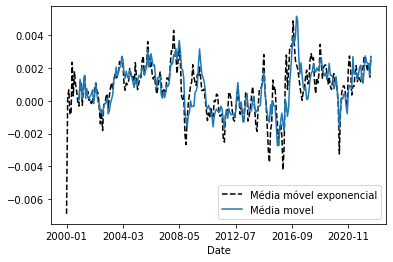

In [14]:
return_ewm = petrobras['Adj Close'].ewm(span=12).mean()
return_mean = petrobras['Adj Close'].rolling(12).mean()
return_ewm.plot(style='k--', label='Média móvel exponencial')
return_mean.plot(label='Média movel')
plt.legend()

### Comparação com índice Ibov ###

#### Um parâmetro interessante de comparação para toda e qualquer ação cotada bolsa brasileira é o Ibovespa. ####

In [15]:
ibov = {indice: web.get_data_yahoo(indice, start_date, end_date) for indice in ['^BVSP']}

In [16]:
ibov = ibov['^BVSP'].pct_change()

In [17]:
ibov.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.028722,-0.051917,-0.011112,-0.063733,NaN,-0.063733
2000-01-05,-0.035841,-0.031607,-0.061332,0.024856,NaN,0.024856
2000-01-06,0.012084,0.040847,0.023061,-0.008495,NaN,-0.008495
2000-01-07,-0.003030,0.009263,-0.006898,0.012541,NaN,0.012541


In [18]:
ibov.index = pd.to_datetime(ibov.index, format='%Y-%m-%d')
ibov = ibov.resample("M").mean()
ibov.index = ibov.index.map(lambda x: x.strftime("%Y-%m"))

In [19]:
ibov.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01,-0.001757,-0.001466,-0.000799,-0.001393,NaN,-0.001393
2000-02,0.003081,0.004026,0.002392,0.003711,NaN,0.003711
2000-03,0.000502,0.000209,0.000532,0.000654,NaN,0.000654
2000-04,-0.006012,-0.006160,-0.006623,-0.006811,NaN,-0.006811
2000-05,-0.001512,-0.001313,-0.000338,-0.001474,NaN,-0.001474


## Correlação entre a variação do preço da ação da Petrobras e a variação do valor do Ibovespa ##

Text(0.5, 1.0, 'Desvio padrão da média móvel do Ibov')

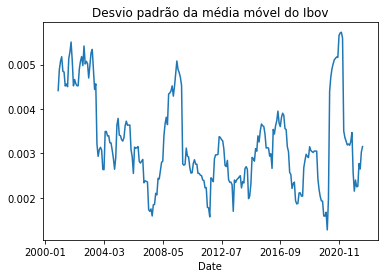

In [20]:
ibov['Adj Close'].rolling(12).std().plot().set_title("Desvio padrão da média móvel do Ibov")

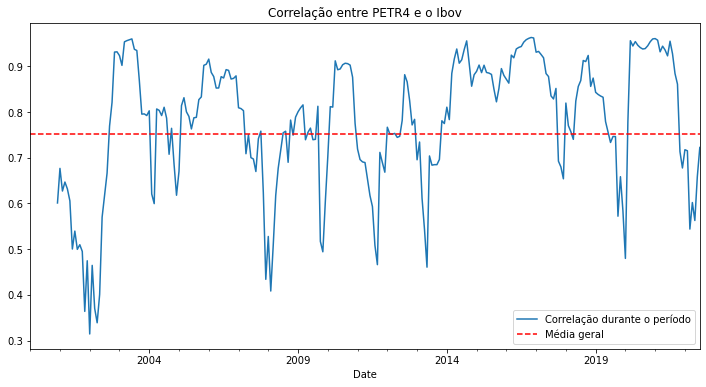

In [21]:
corr_ibov = petrobras['Adj Close'].rolling(12).corr(ibov['Adj Close'])
corr_ibov.index = pd.to_datetime(corr_ibov.index, format="%Y-%m")

fig, ax = plt.subplots(figsize=(12,6))
corr_ibov.plot(label="Correlação durante o período").set_title("Correlação entre PETR4 e o Ibov")
plt.axhline(y =  petrobras['Adj Close'].corr(ibov['Adj Close']), color='red', ls='--', label="Média geral")
plt.legend()
plt.show()

### Nota-se que há, durante a maior parte do período, uma forte correlação entre a ação PETR4 e o Ibov, que inclusive possui em sua carteira tanto PETR4 quanto PETR3. Na média a correlação se mante eleveda, entre 0.7 e 0.8.

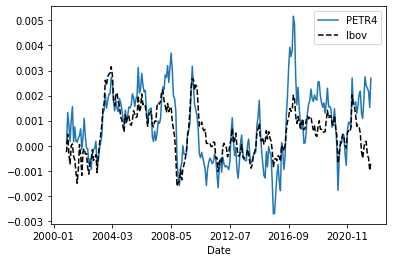

In [22]:
fig, ax = plt.subplots()
ax = petrobras['Adj Close'].rolling(12).mean().plot(label='PETR4')
fig = ibov['Adj Close'].rolling(12).mean().plot(style="k--", label='Ibov')
plt.legend()
plt.show()

### Pode-se notar, a partir das médias móveis, que de modo geral a variação no preço da ação PETR4 tende a acompanhar a variação do Ibov, havendo em determinados períodos alguns desvios mais evidentes, como o ocorrido em 2016.

### Comparação compreço global do petróleo Brent ###

#### Outro parâmetro relevante para ser utilizado nesse caso é o preço global do petróleo. ####

In [23]:
oil = {brent: web.get_data_fred(brent, start_date, end_date) for brent in ['POILBREUSDM']}

In [24]:
oil = oil['POILBREUSDM'].pct_change()

In [25]:
oil.index = pd.to_datetime(oil.index, format="%Y-%m-%d")
oil.index = oil.index.map(lambda x: x.strftime("%Y-%m"))

In [26]:
oil.head()

,POILBREUSDM
DATE,
2000-01,NaN
2000-02,0.095559
2000-03,-0.005791
2000-04,-0.179469
2000-05,0.215617


Text(0.5, 1.0, 'Desvio padrão da média móvel do preço global do petróleo')

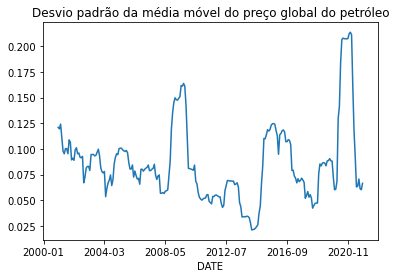

In [27]:
oil['POILBREUSDM'].rolling(12).std().plot().set_title("Desvio padrão da média móvel do preço global do petróleo")

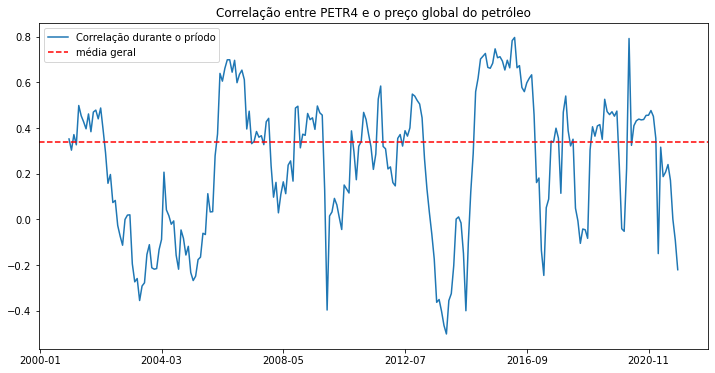

In [28]:
corr_brent = petrobras['Adj Close'].rolling(12).corr(oil['POILBREUSDM'])

ax,fig = plt.subplots(figsize=(12,6))
corr_brent.plot(label="Correlação durante o príodo").set_title("Correlação entre PETR4 e o preço global do petróleo")
plt.axhline(petrobras['Adj Close'].corr(oil['POILBREUSDM']), color='red', ls='--', label="média geral")
plt.legend()
plt.show()

#### Apesar do correlação média ser consideravelmente menor do que a referente ao Ibov, nota-se que há, principalmente em determinados períodos, uma correlação significativa entre o preço da ação PETR4 e do preço global do petróleo ###

# Aplicação do modelo ARIMA #

In [30]:
decompose = sm.tsa.seasonal_decompose(petrobras['Adj Close'].values, freq=12).plot()

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

### Normalidade dos dados ###

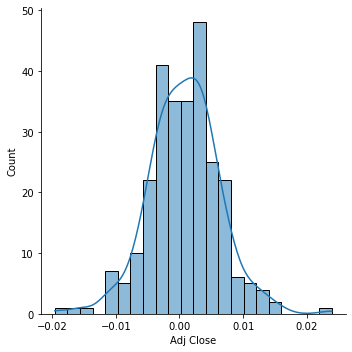

In [31]:
sns.displot(data = petrobras, x = 'Adj Close', kde = True)

### Teste de estacionáridade ###

In [32]:
estacionaridade = adfuller(petrobras['Adj Close'].values)

print('ADF Statistic: %f' % estacionaridade[0])
print('P-Value: %f' % estacionaridade[1])
print('Critical Values:')
for key,values in estacionaridade[4].items():
  print('\t%s: %.3f' % (key, values))

ADF Statistic: -13.078467
P-Value: 0.000000
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573


### Autocorrelação

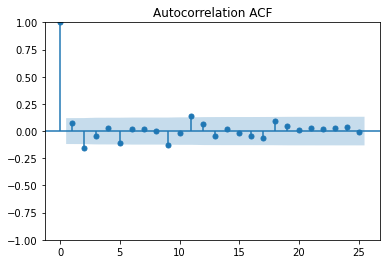

In [33]:
sm.graphics.tsa.plot_acf(petrobras['Adj Close'], title='Autocorrelation ACF')

plt.show()

/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


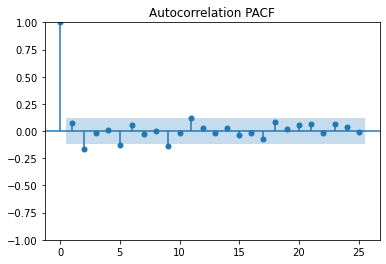

In [34]:
sm.graphics.tsa.plot_pacf(petrobras['Adj Close'].values, title='Autocorrelation PACF')

plt.show()

### Criação do modelo

In [35]:
x = pd.DataFrame(petrobras['Adj Close'])
x.index = pd.to_datetime(x.index, format=("%Y-%m"))
modelo = ARIMA(x, order=(12,0,12))
modelo_fit = modelo.fit()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


### Análise dos resíduos

In [36]:
residual = modelo_fit.resid

NameError: name 'modelo_fit' is not defined

NameError: name 'residual' is not defined

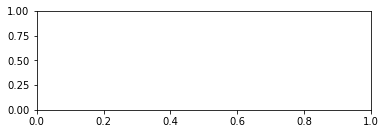

In [37]:
fig = plt.figure()

plt.subplot(2,1,1)
plt.plot(residual)

plt.subplot(2,1,2)
sns.histplot(residual, kde=True, legend=False)

plt.show()

### Cross validation approach

NameError: name 'modelo_fit' is not defined

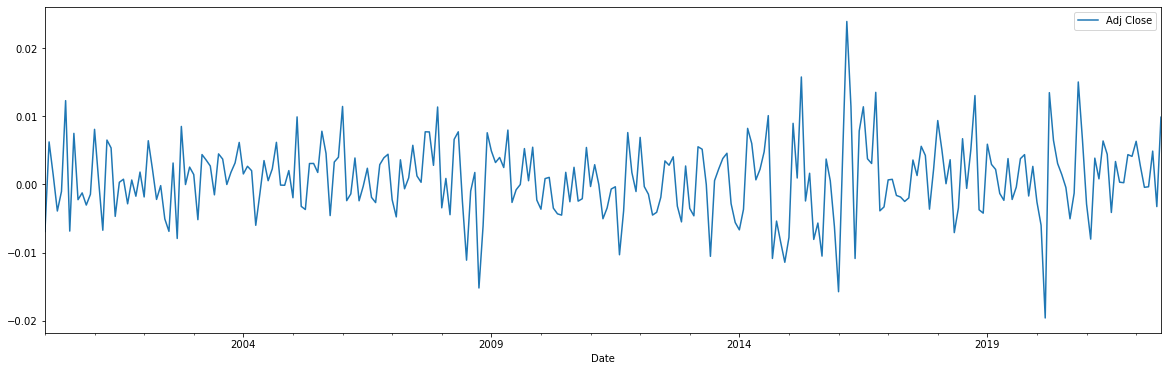

In [38]:
fig, ax = plt.subplots(figsize=(20,6))
ax = x.plot(ax=ax)
fig = modelo_fit.plot_predict(start = '2017-01', end = '2021-02', ax=ax, dynamic=True, plot_insample=False)
plt.show()

# Tentativa de prever a variação com um modelo Random Forest

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score
import math

teste = x['2017-01':]
previsao = modelo_fit.predict(start='2017-01', end='2021-02')

r2_score(teste, previsao)

NameError: name 'modelo_fit' is not defined

In [40]:
MSE = mean_squared_error(teste, previsao)
RMSE = math.sqrt(MSE)
RMSE

NameError: name 'previsao' is not defined

In [41]:
mean_absolute_error(teste, previsao)

NameError: name 'previsao' is not defined

In [42]:
X = pd.concat([oil, ibov['Adj Close']], axis=1)
Y = petrobras['Adj Close']

In [43]:
X.rename(columns={"Adj Close":"Ibov"}, inplace=True)

In [44]:
X.POILBREUSDM.fillna(X.POILBREUSDM.mean(), inplace=True)

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [46]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=False)

In [47]:
modelo = RandomForestRegressor()
modelo.fit(x_train, y_train)

RandomForestRegressor()

In [48]:
predicao = modelo.predict(x_test)

In [49]:
r2_score(y_test, predicao)

0.5025313342708093

In [50]:
MSE = np.square(np.subtract(y_test, predicao)).mean()
RMSE = math.sqrt(MSE)
RMSE

0.004031476159875529

In [51]:
mean_absolute_error(y_test, predicao)

0.003234130809317838

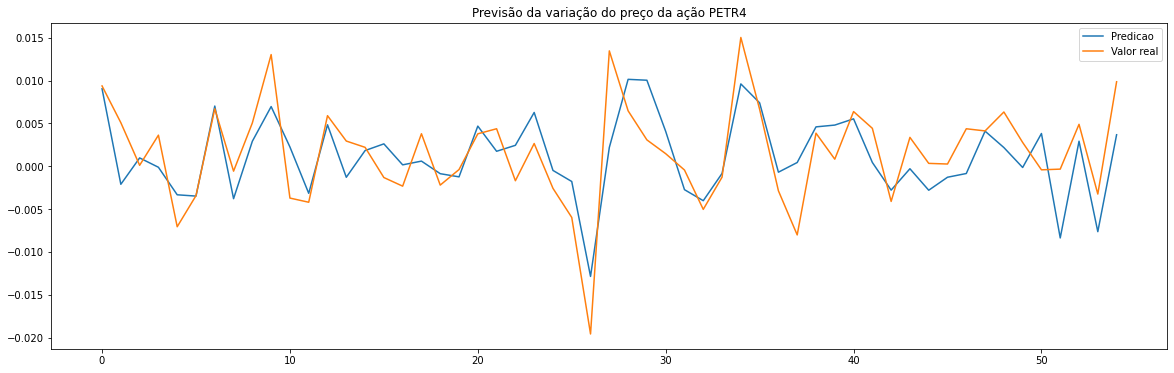

In [52]:
ax, fig = plt.subplots(figsize=(20,6))
plt.plot(predicao, label='Predicao')
plt.plot(y_test.values, label='Valor real')
plt.title("Previsão da variação do preço da ação PETR4")
plt.legend()
plt.show()

# Tentativa de prever a variação através de deep learning

In [53]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
import tensorflow as tf

ModuleNotFoundError: No module named 'keras'

In [ ]:
def build_model():
  model = keras.Sequential([
    Dense(64, activation='relu', input_shape=[len(x_train.keys())]),
    Dense(64, activation='relu'),
    Dense(1)
  ])

  model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])
  return model

In [ ]:
modelo_keras = build_model()

In [ ]:
modelo_keras.summary()

In [ ]:
modelo_keras.fit(x_train, y_train, batch_size=10, epochs=500)

In [ ]:
predicao2 = modelo_keras.predict(x_test)

In [ ]:
ax, fig = plt.subplots(figsize=(20,6))
plt.plot(predicao2, label="Predição")
plt.plot(y_test.values, label="Valor real")
plt.title("Predição da variação do preço da ação PETR4")
plt.legend()
plt.show()